## Goal:
Classify Positive/Negative Sentiment from comments in Ruby Rivlin Facebook Page.

In [1]:
import numpy as np 
import pandas as pd 
import re  
import nltk 
import codecs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import csv
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google_trans_new import google_translator  
nltk.download('stopwords')  
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import naive_bayes, svm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramirc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data files

In [2]:
#token - Original data
token_train = pd.read_csv("data/token_train.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)
token_test = pd.read_csv("data/token_test.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)

#morph - Data after morphologic processing
morph_train = pd.read_csv("data/morph_train.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)
morph_test = pd.read_csv("data/morph_test.tsv", sep='\t', quoting=csv.QUOTE_NONE, header=None)

#token_eng - Data after english translation (using google translate)
token_train_eng = pd.read_csv("data/token_train_english.csv", header=None)
token_test_eng = pd.read_csv("data/token_test_english.csv", header=None)

In [3]:
print(token_train.shape)
print(morph_train.shape)
print(token_train_eng.shape)

(10244, 2)
(10244, 2)
(10244, 2)


In [4]:
token_train.head()

,0,1
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0
1,איש יקר שלנו,0
2,כל הכבוד והמון בהצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0


## Plot train data sentiments distribution
We can see that most of the comments are possitive

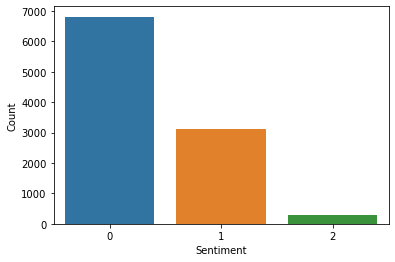

In [5]:
ax = sns.countplot(x=1, data=token_train);
ax.set(xlabel='Sentiment', ylabel='Count')
plt.show()

## FIRST MODEL
Using Random Forest classifier based on TD-IDF

## Prepare the data for models

In [6]:
#Split all data sets to the comments(X) and the sentimnet(y) 


X_token_train = token_train.iloc[:, 0].values
y_token_train = token_train.iloc[:, 1].values
X_token_test = token_test.iloc[:, 0].values
y_token_test = token_test.iloc[:, 1].values

X_morph_train = morph_train.iloc[:, 0].values
y_morph_train = morph_train.iloc[:, 1].values
X_morph_test = morph_test.iloc[:, 0].values
y_morph_test = morph_test.iloc[:, 1].values

X_token_train_eng = token_train_eng.iloc[:, 0].values
y_token_train_eng = token_train_eng.iloc[:, 1].values
X_token_test_eng = token_test_eng.iloc[:, 0].values
y_token_test_eng = token_test_eng.iloc[:, 1].values

In [7]:
#proccess_text function will get text array and clean it with regex expressions
def process_text(arr, lang):
    processed_arr = []
    
    if lang=="he":
        for text in range(0, len(arr)):  
            processed_text = re.sub(r'[\a-z]+', ' ', str(arr[text]))
            processed_arr.append(processed_text)
            
    elif lang=="eng":
        for text in range(0, len(arr)):  
            # Remove all the special characters
            processed_text = re.sub(r'\W', ' ', str(arr[text]))

            # Remove all digits
            #processed_text = re.sub(r'\d+', ' ', processed_text)

            # remove all single characters
            processed_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)

            # Remove single characters from the start
            processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text) 

            # Substituting multiple spaces with single space
            processed_text= re.sub(r'\s+', ' ', processed_text, flags=re.I)

            # Removing prefixed 'b'
            processed_text = re.sub(r'^b\s+', '', processed_text)

            # Converting to Lowercase
            processed_text = processed_text.lower()
            processed_arr.append(processed_text)
    
    return processed_arr

In [8]:
#Translate text using google translate API (not in use, i translated the data file outside the notebook)
'''def translate_text(arr):
    translator = google_translator()  
    english_list = []
    for text in arr:
        translated_text = translator.translate(text,lang_src='he',lang_tgt='en')  
        english_list.append(translated_text)
    return np.array(english_list)'''

"def translate_text(arr):\n    translator = google_translator()  \n    english_list = []\n    for text in arr:\n        translated_text = translator.translate(text,lang_src='he',lang_tgt='en')  \n        english_list.append(translated_text)\n    return np.array(english_list)"

In [9]:
#Clean Datasets

X_token_train_processed = process_text(X_token_train,"he")
X_token_test_processed = process_text(X_token_test,"he")

X_morph_train_processed = process_text(X_morph_train,"he")
X_morph_test_processed = process_text(X_morph_test,"he")

X_token_train_eng_processed = process_text(X_token_train_eng,"eng")
X_token_test_eng_processed = process_text(X_token_test_eng,"eng")

In [10]:
X_token_train_eng_processed[0:5]

['it really hurts cry with the family that you will not know any more grief',
 'our dear man',
 'well done and good luck',
 'tel hai ruby in all this sadness you were ray of light of hope there is indeed president in israel',
 'clean hands and hearty good luck to you and us ']

Create feature vectors containing TF-IDF values
- max_features - The number of words that we will create feature for.
- min_df - Specify that a word should be occur at least 5 times to treat as feature
- max_df = Specify that a word will not occur in more of 70% of the data

In [11]:
tfidf_token_converter = TfidfVectorizer(max_features=3000, min_df=5, max_df=0.7)  

tfidf_morph_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

tfidf_token_eng_converter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)  

In [12]:
#We will use only the train data to fit (create the features) and than we will transform both train and dataset.

tfidf_token_converter.fit(X_token_train_processed)
X_token_train = tfidf_token_converter.transform(X_token_train_processed).toarray()
X_token_test = tfidf_token_converter.transform(X_token_test_processed).toarray()

tfidf_morph_converter.fit(X_morph_train_processed)
X_morph_train = tfidf_morph_converter.transform(X_morph_train_processed).toarray()
X_morph_test = tfidf_morph_converter.transform(X_morph_test_processed).toarray()

tfidf_token_eng_converter.fit(X_token_train_eng_processed)
X_token_train_eng = tfidf_token_eng_converter.transform(X_token_train_eng_processed).toarray()
X_token_test_eng = tfidf_token_eng_converter.transform(X_token_test_eng_processed).toarray()

## Build Classifier
I will use random forest to classify the data

In [13]:
token_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
token_classifier.fit(X_token_train, y_token_train)

morph_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
morph_classifier.fit(X_morph_train, y_morph_train)

token_eng_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
token_eng_classifier.fit(X_token_train_eng, y_token_train_eng)

RandomForestClassifier(random_state=0)

## Predict

In [14]:
token_predictions = token_classifier.predict(X_token_test)
morph_predictions = morph_classifier.predict(X_morph_test)
token_eng_predictions = token_eng_classifier.predict(X_token_test_eng)

We can see that we get similiar results in all datasets ~92% accuracy.

In [15]:
print("token model")
print(confusion_matrix(y_token_test, token_predictions))  
print(classification_report(y_token_test, token_predictions))  
print(accuracy_score(y_token_test, token_predictions))

print("\nmorph model")
print(confusion_matrix(y_morph_test, morph_predictions))  
print(classification_report(y_morph_test, morph_predictions))  
print(accuracy_score(y_morph_test, morph_predictions))

print("token_eng model")
print(confusion_matrix(y_token_test_eng, token_eng_predictions))  
print(classification_report(y_token_test_eng, token_eng_predictions))  
print(accuracy_score(y_token_test_eng, token_eng_predictions))

token model
[[1622   74    2]
 [  91  698    1]
 [  20   15   37]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1698
           1       0.89      0.88      0.89       790
           2       0.93      0.51      0.66        72

    accuracy                           0.92      2560
   macro avg       0.92      0.78      0.83      2560
weighted avg       0.92      0.92      0.92      2560

0.920703125

morph model
[[1634   61    3]
 [ 100  690    0]
 [  17   18   37]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1698
           1       0.90      0.87      0.89       790
           2       0.93      0.51      0.66        72

    accuracy                           0.92      2560
   macro avg       0.92      0.78      0.83      2560
weighted avg       0.92      0.92      0.92      2560

0.922265625
token_eng model
[[1643   48    7]
 [ 102  684    4]
 [  16   15   41]]
        

We can see the diffrences between the features of the datasets

In [33]:
#tfidf_token_converter.get_feature_names()

In [32]:
#tfidf_morph_converter.get_feature_names()

In [31]:
#tfidf_token_eng_converter.get_feature_names()

## SECOND MODEL
Using SVM classifier based on TD-IDF and POS Tagger
I will use only the english dataset, so i will be able to use nltk pos_tag

In [19]:
#process_eng_text_series function will get text Serier and clean it with regex expressions
def process_eng_text_series(series):

    for i,text in enumerate(series):  
        # Remove all the special characters
        text = re.sub(r'\W', ' ', str(text))

        # Remove all digits
        #processed_text = re.sub(r'\d+', ' ', processed_text)
        
        # remove all single characters
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

        # Remove single characters from the start
        text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

        # Substituting multiple spaces with single space
        text= re.sub(r'\s+', ' ', text, flags=re.I)

        # Removing prefixed 'b'
        text = re.sub(r'^b\s+', '', text)

        # Converting to Lowercase
        text = text.lower()
        
        series[i] = text

In [20]:
#Put labels on the coloumns
token_train_eng = token_train_eng.rename(columns = {0: 'text', 1: 'label'}, inplace = False)
token_test_eng = token_test_eng.rename(columns = {0: 'text', 1: 'label'}, inplace = False)

In [21]:
#Clean dataset using process_eng_text_series function
process_eng_text_series(token_train_eng['text'])
process_eng_text_series(token_test_eng['text'])

<ipython-input-19-6b885cfa3a50>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[i] = text


In [22]:
#word_tokenize will get text and return it tokenized in list
token_train_eng['text']= [word_tokenize(entry) for entry in token_train_eng['text']]
token_test_eng['text']= [word_tokenize(entry) for entry in token_test_eng['text']]

In [23]:
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [24]:
#data_lemmatization function will get dataset and lemmatize the text.
#lemmatization is the process of converting a word to its base form.
def data_lemmatization(data):
    for index,entry in enumerate(data['text']):
        Final_words = []
        word_Lemmatized = WordNetLemmatizer()
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)

        data.loc[index,'text_final'] = str(Final_words)

In [25]:
data_lemmatization(token_train_eng)

In [26]:
data_lemmatization(token_test_eng)

In [27]:
#Seperate the text and the sentiment labels
token_train_eng_X = token_train_eng['text_final']
token_train_eng_Y = token_train_eng['label']
token_test_eng_X = token_test_eng['text_final']
token_test_eng_Y = token_test_eng['label']

In [28]:
token_train_eng_Y = token_train_eng_Y.values
token_test_eng_Y = token_test_eng_Y.values

In [29]:
#Create feature vectors containing TF-IDF values
Tfidf_vect_eng = TfidfVectorizer(max_features=2000)
Tfidf_vect_eng.fit(token_train_eng['text_final'])
token_train_eng_X_Tfidf = Tfidf_vect_eng.transform(token_train_eng_X)
token_test_eng_X_Tfidf = Tfidf_vect_eng.transform(token_test_eng_X)

## Build Classifier
I will use SVM to classify the data

In [30]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(token_train_eng_X_Tfidf,token_train_eng_Y)

predictions_SVM = SVM.predict(token_test_eng_X_Tfidf)

print("token_eng model")
print(confusion_matrix(token_test_eng_Y, predictions_SVM))  
print(classification_report(token_test_eng_Y, predictions_SVM))  
print(accuracy_score(token_test_eng_Y, predictions_SVM))

token_eng model
[[1592   98    8]
 [ 160  624    6]
 [  28   21   23]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1698
           1       0.84      0.79      0.81       790
           2       0.62      0.32      0.42        72

    accuracy                           0.87      2560
   macro avg       0.79      0.68      0.72      2560
weighted avg       0.87      0.87      0.87      2560

0.874609375


## With the Random Forest Classifier (FIRST MODEL) i achieved better results than the SVM classfier.